
# Adjusting Incidence for Positive Rate, Hospital Occupancy and Vaccination 

## Load and Prepare Data

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings

In [2]:
# load data [30Mb!]
full_data = pd.read_csv('owid-covid-data.csv')
# docu at: https://github.com/owid/covid-19-data/tree/master/public/data
# 100k rows, 60 cols

# convert date variable to pd.Timestamp object
full_data.date = pd.to_datetime(full_data.date)

In [3]:
# Extract Relevant Columns 
cases_icu = full_data[['location',  'date', 'new_cases_smoothed_per_million', 'positive_rate',
                               'icu_patients_per_million', 'people_fully_vaccinated_per_hundred',
                               'weekly_icu_admissions_per_million']]

In [4]:
# extract floats and location
floats = cases_icu.dtypes == 'float64'
floats_names = np.append(cases_icu.columns.values[floats.values], 'location')
subdf_floats = cases_icu[floats_names]

In [5]:
transformed_cases_icu = subdf_floats.groupby('location').transform(lambda col: ((col - col.min())) / (col.max() - col.min()))
# compute positive rate to incidence ratio on normalized data
pr2in_ratio = transformed_cases_icu.positive_rate/transformed_cases_icu.new_cases_smoothed_per_million
cases_icu.insert(loc=1, column='pr2in_ratio', value=pr2in_ratio)

# or use individual columns
# cases_icu.insert(loc=1, column='norm_posrate', value=transformed_cases_icu.positive_rate)
# cases_icu.insert(loc=1, column='norm_incidence', value=transformed_cases_icu.new_cases_smoothed_per_million)

## Correct Incidence for Positive Rate and Group by Country

### Normalize and Compute PR to Incidence Ratio

In [6]:
# Add Column for adjusted Incidence
# Parameterize influence of Positive Rate
alpha = 1.3
# Account for posrate above given threshold
threshold = 2.5
# Add baseline factor to scale values
baseline_factor = 5**alpha

adj_incidence = cases_icu['new_cases_smoothed_per_million']*(cases_icu['positive_rate']*100)**alpha
cases_icu.insert(loc=0, column='adj_incidence', value=adj_incidence)

psm1 = [(row.adj_incidence if row.pr2in_ratio > threshold else row.new_cases_smoothed_per_million*baseline_factor) for _, row in cases_icu.iterrows()]
cases_icu.insert(loc=1, column='psm1', value=psm1)

# Group by Country
cases_icu_grouped = cases_icu.groupby('location')

In [7]:
# Get names of locations/ countries for which ICU data is available
icu_admissions_countries = []
icu_countries = []

for location, group in cases_icu_grouped:
    if not group['weekly_icu_admissions_per_million'].isnull().values.all():
        icu_admissions_countries.append(location)
    if not group['icu_patients_per_million'].isnull().values.all():
        icu_countries.append(location)
        
print('Weekly ICU-Admissions available for: \n', icu_admissions_countries, '\n')
print('ICU-Patients (on a given day) available for: \n', icu_countries)

Weekly ICU-Admissions available for: 
 ['Cyprus', 'Czechia', 'Estonia', 'France', 'Greece', 'Ireland', 'Israel', 'Latvia', 'Liechtenstein', 'Lithuania', 'Malta', 'Netherlands', 'Norway', 'Slovenia', 'Spain', 'Sweden'] 

ICU-Patients (on a given day) available for: 
 ['Algeria', 'Austria', 'Belgium', 'Bulgaria', 'Canada', 'Cyprus', 'Czechia', 'Denmark', 'Estonia', 'Finland', 'France', 'Germany', 'Ireland', 'Israel', 'Italy', 'Luxembourg', 'Netherlands', 'Portugal', 'Romania', 'Slovenia', 'Spain', 'Sweden', 'United Kingdom', 'United States']


### !! any problems with NAs?

## Plot Results: Correlation with ICU <u> Admissions </u>

<ipython-input-8-45df6fc59c07>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.interpolate(method='linear', inplace=True)
<ipython-input-8-45df6fc59c07>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.interpolate(method='linear', inplace=True)
<ipython-input-8-45df6fc59c07>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.interpolate(method='linear', inplace=True)
<ipython-input-8-45df6fc59c07>:6: SettingWithCopyWarning: 
A 

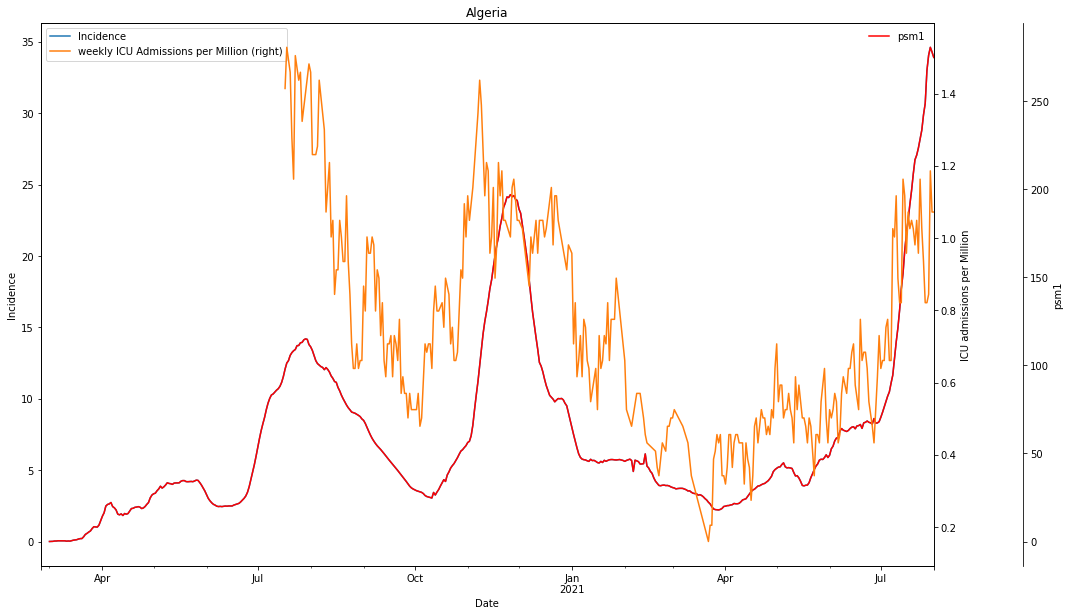

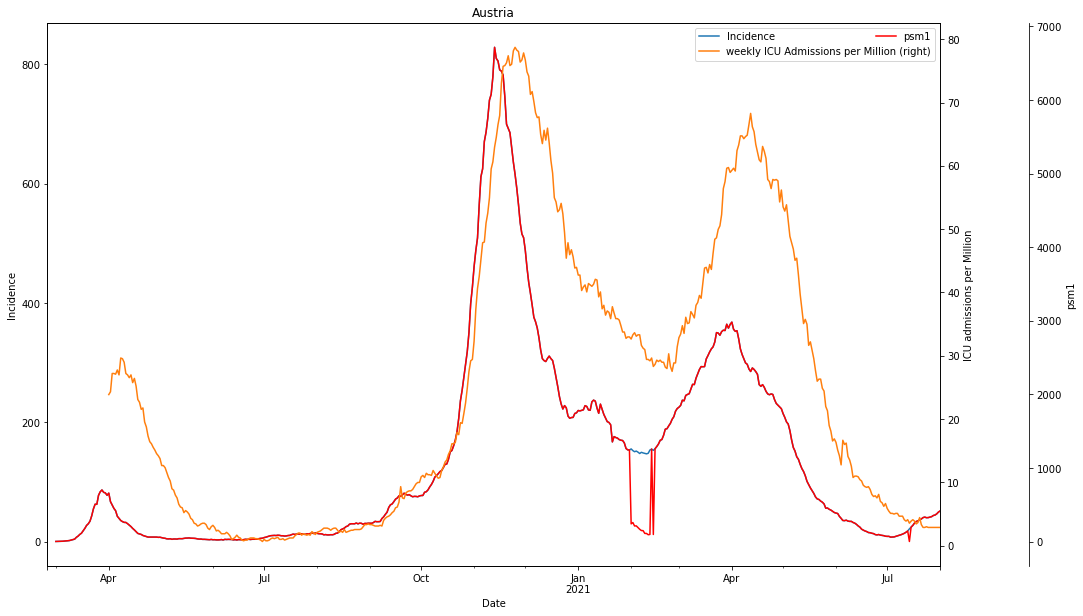

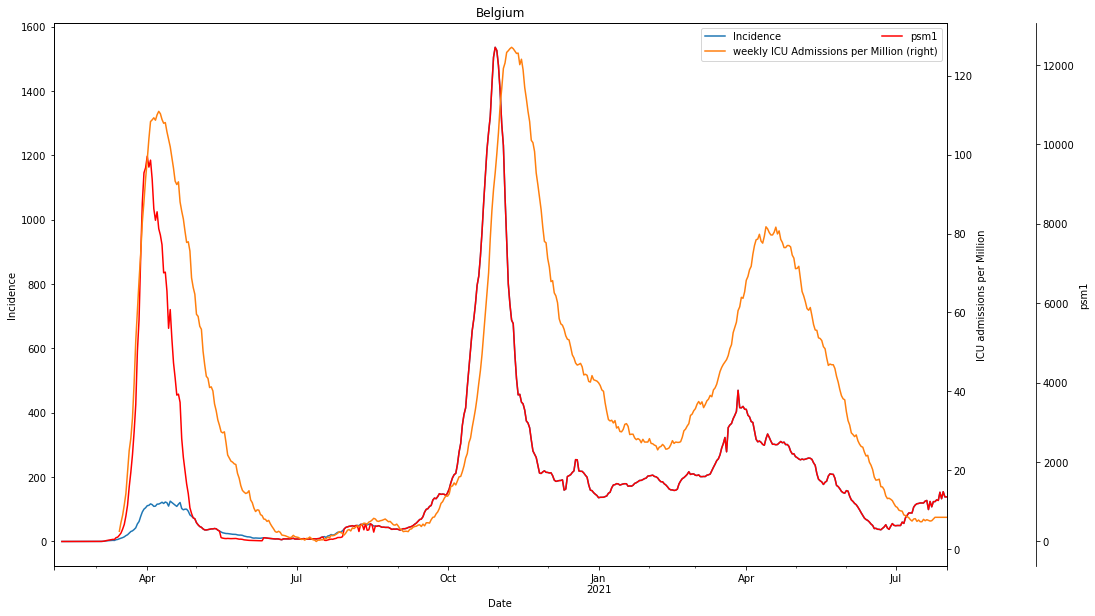

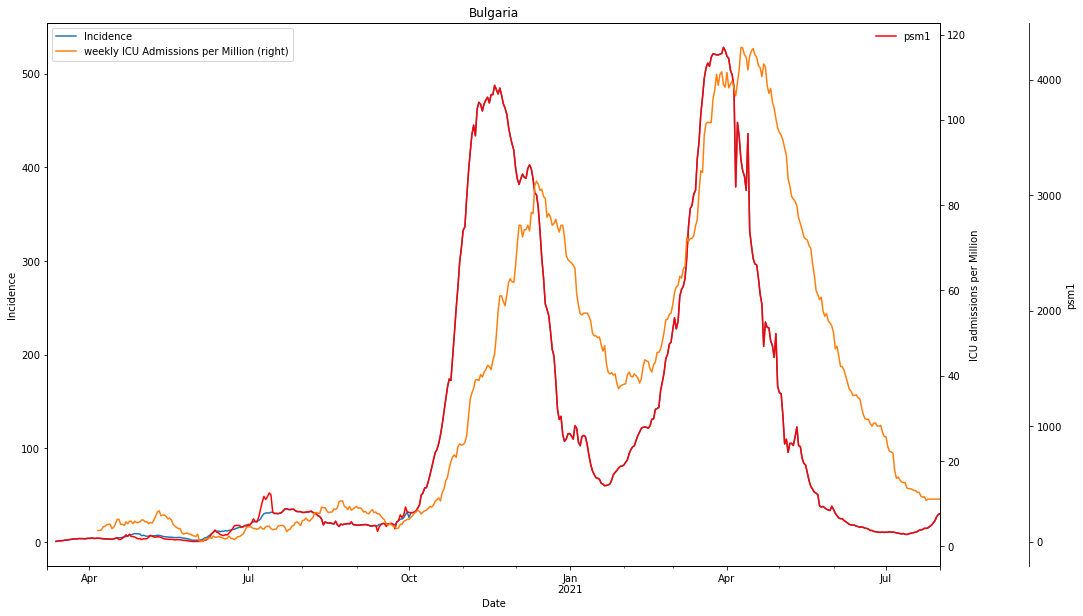

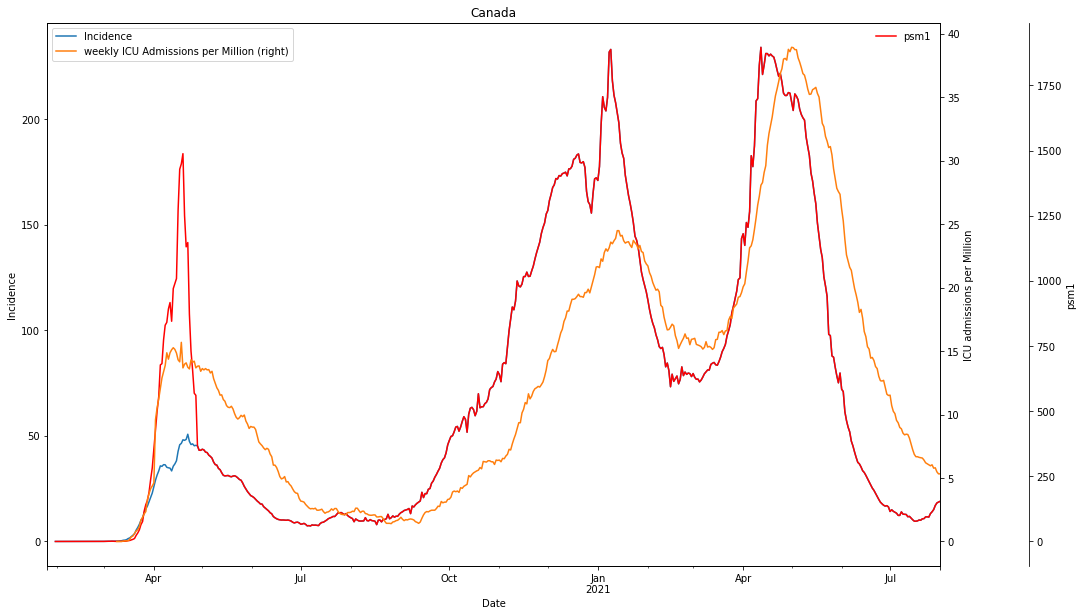

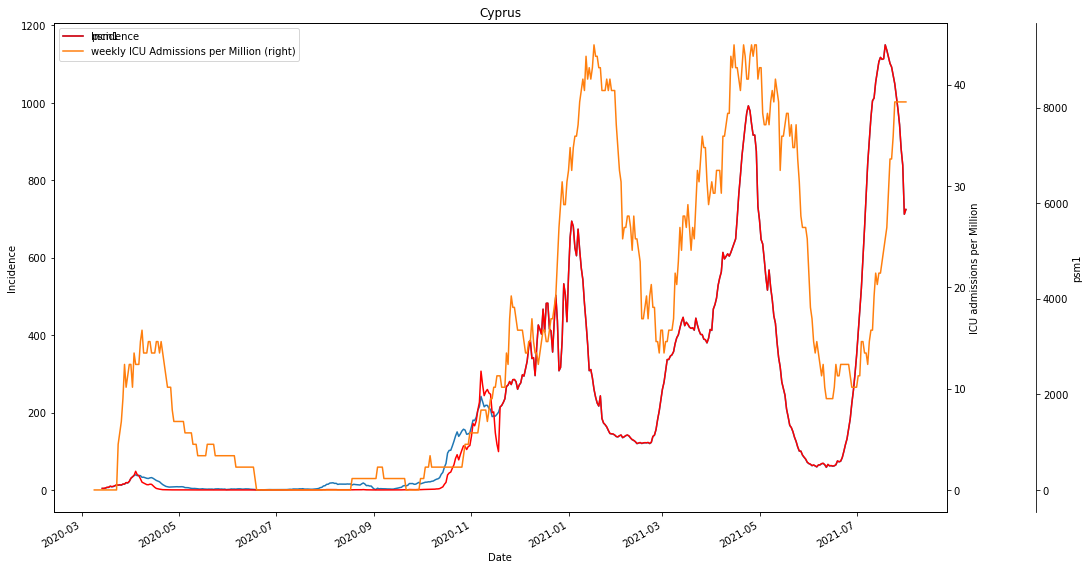

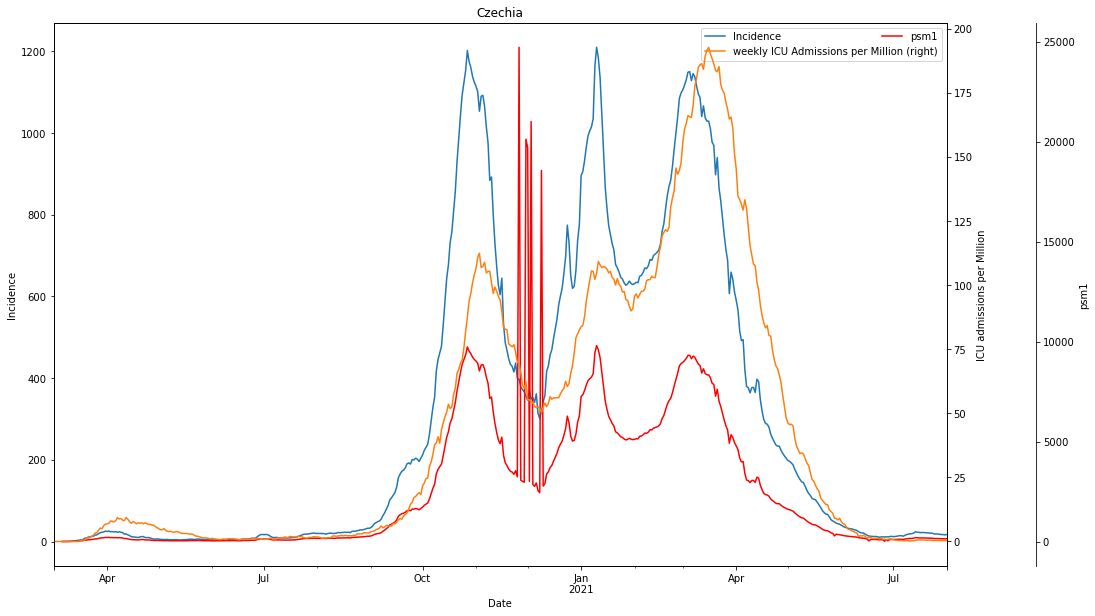

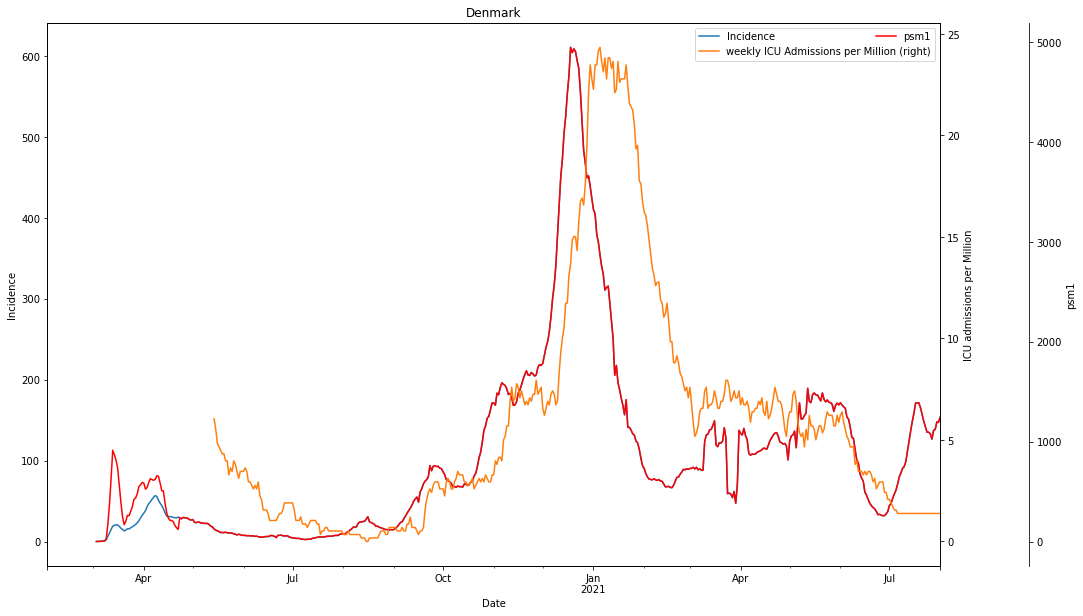

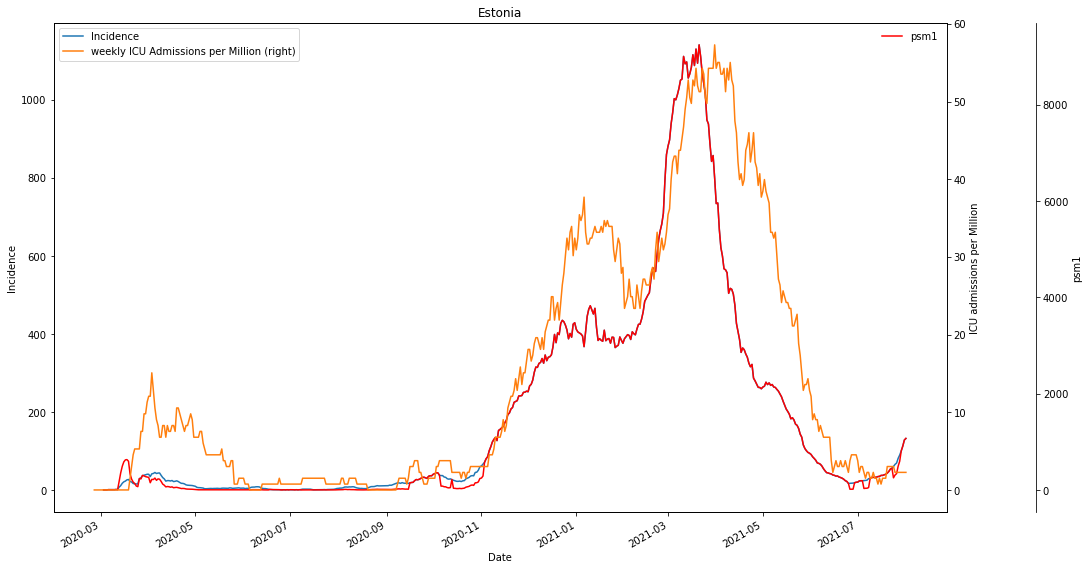

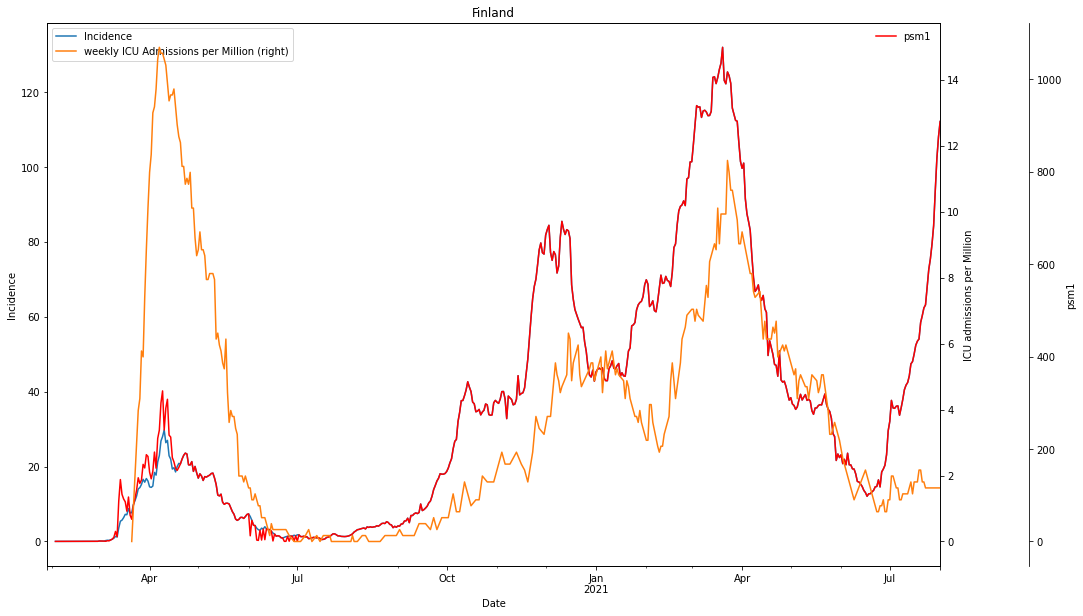

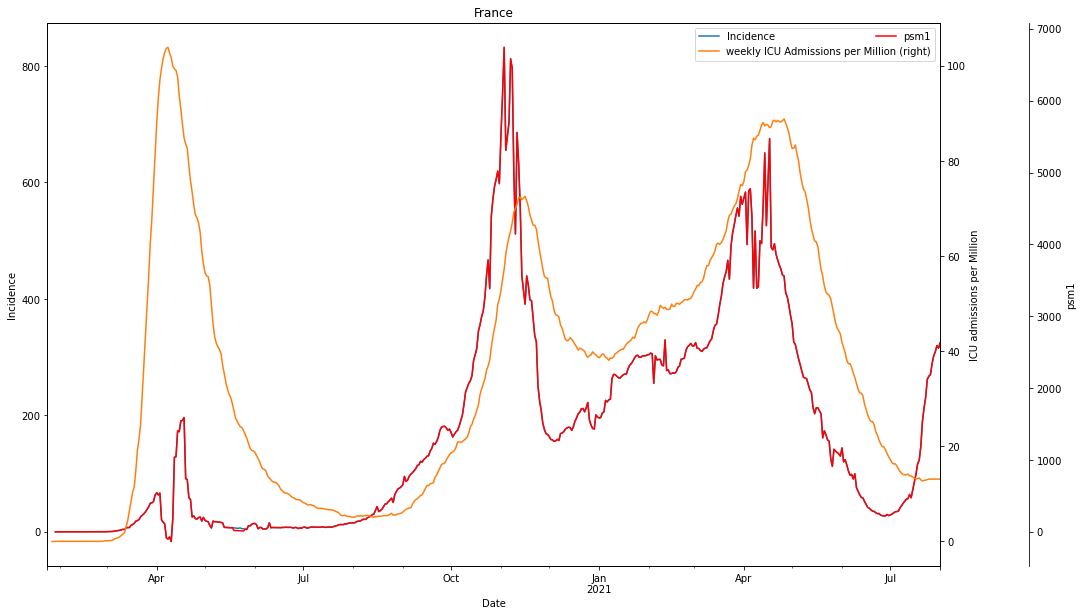

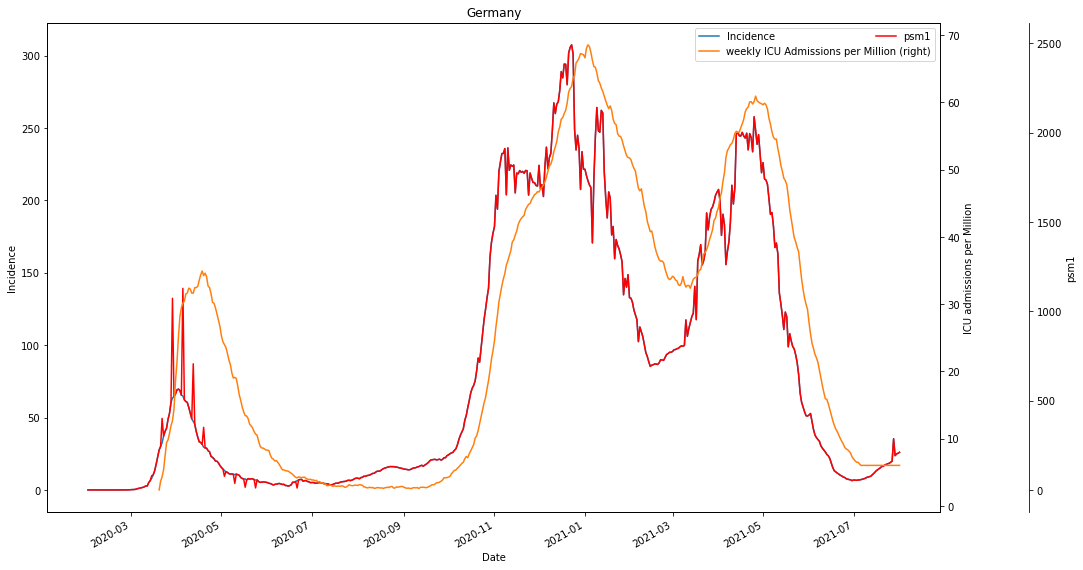

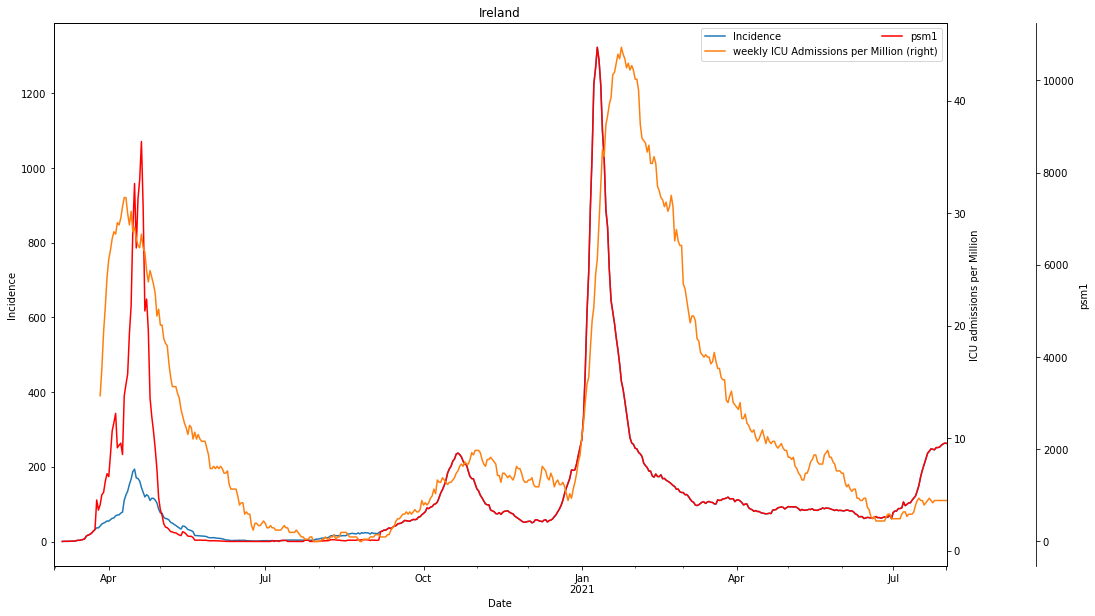

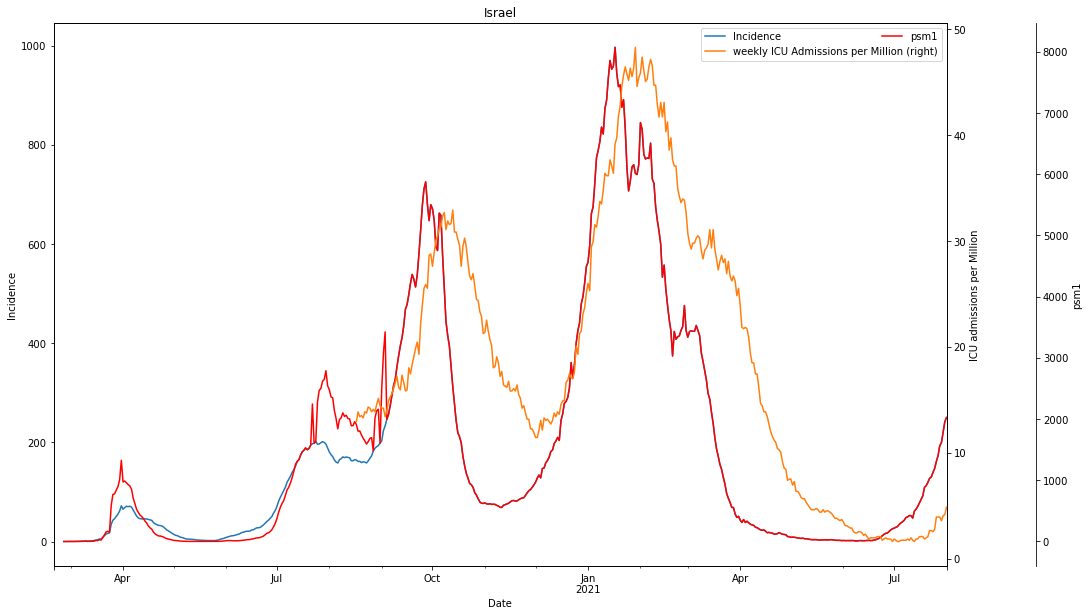

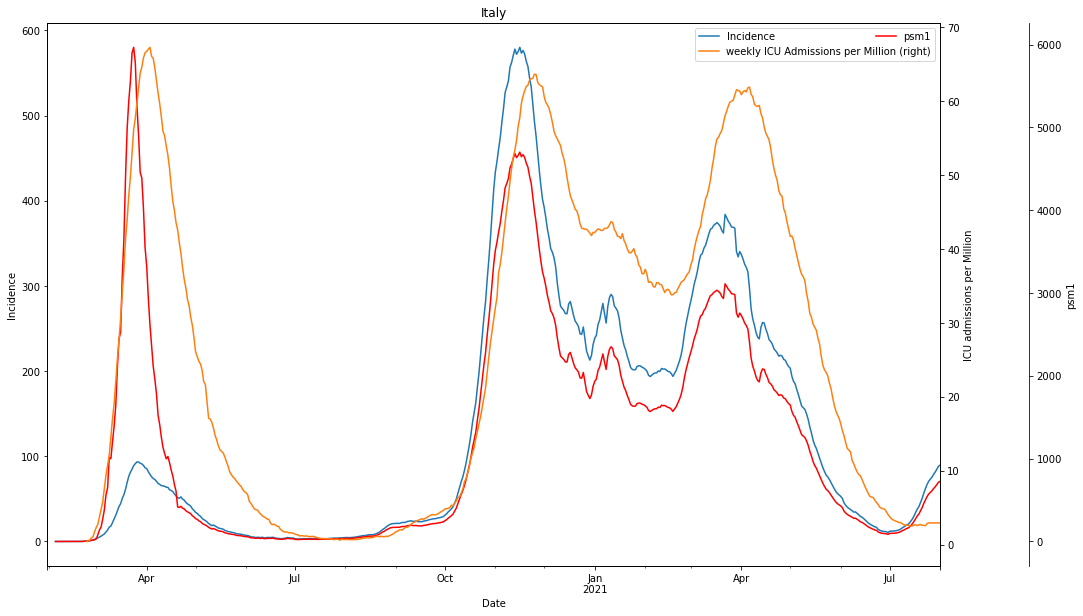

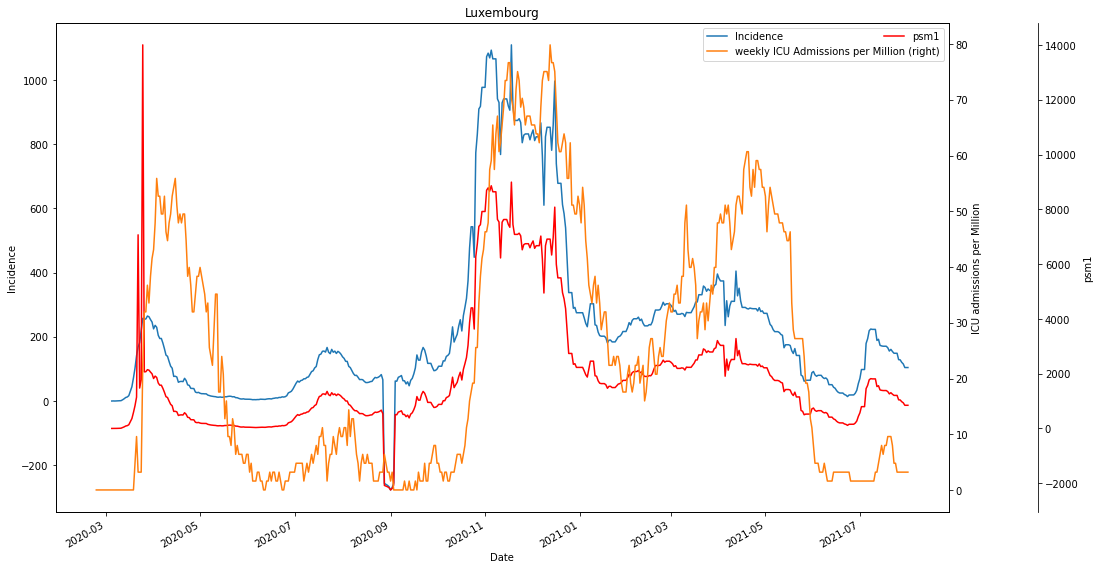

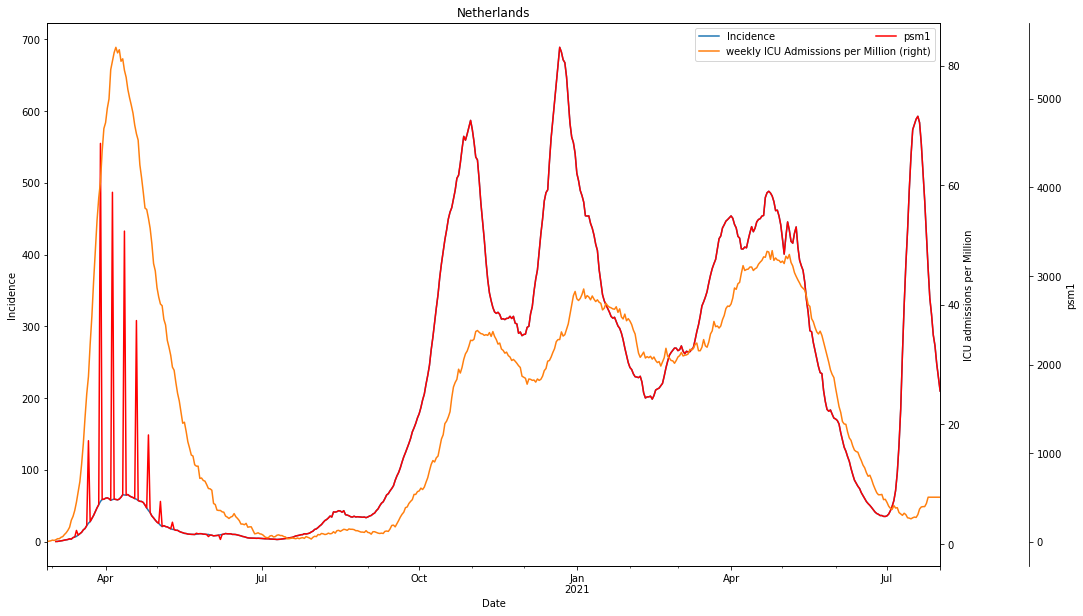

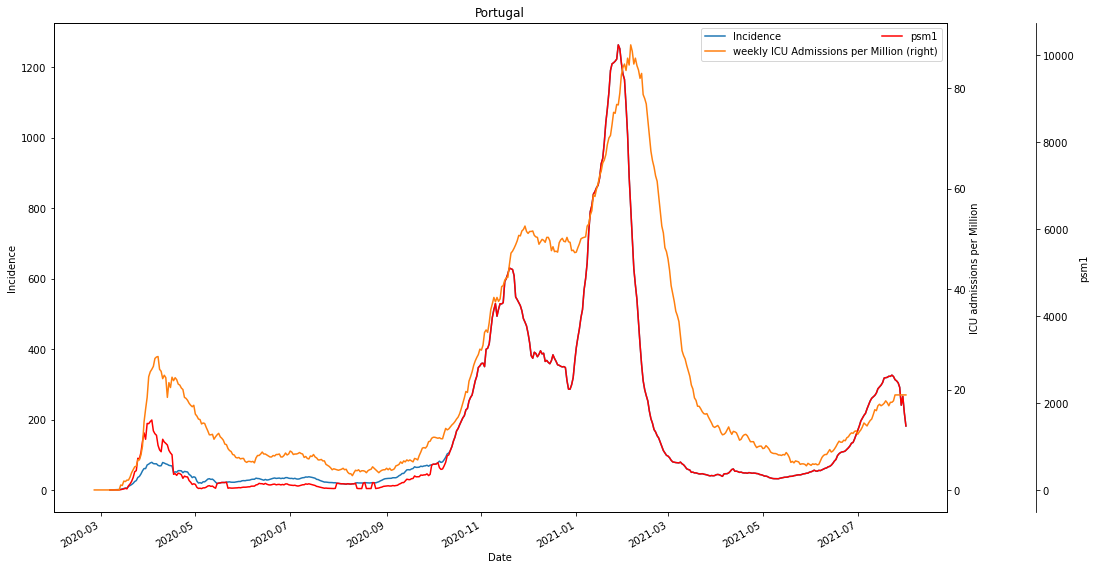

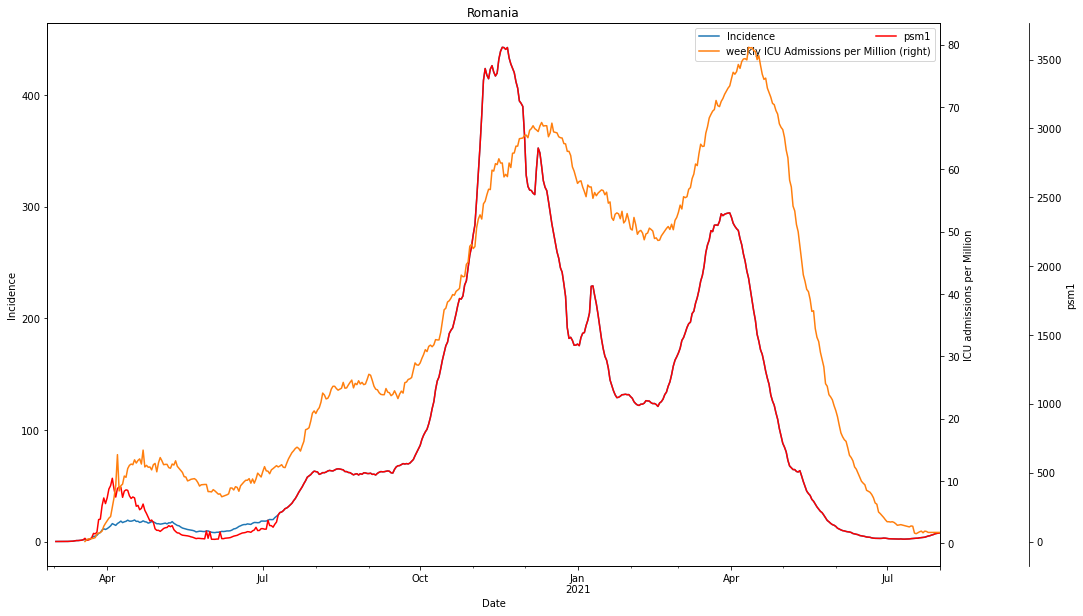

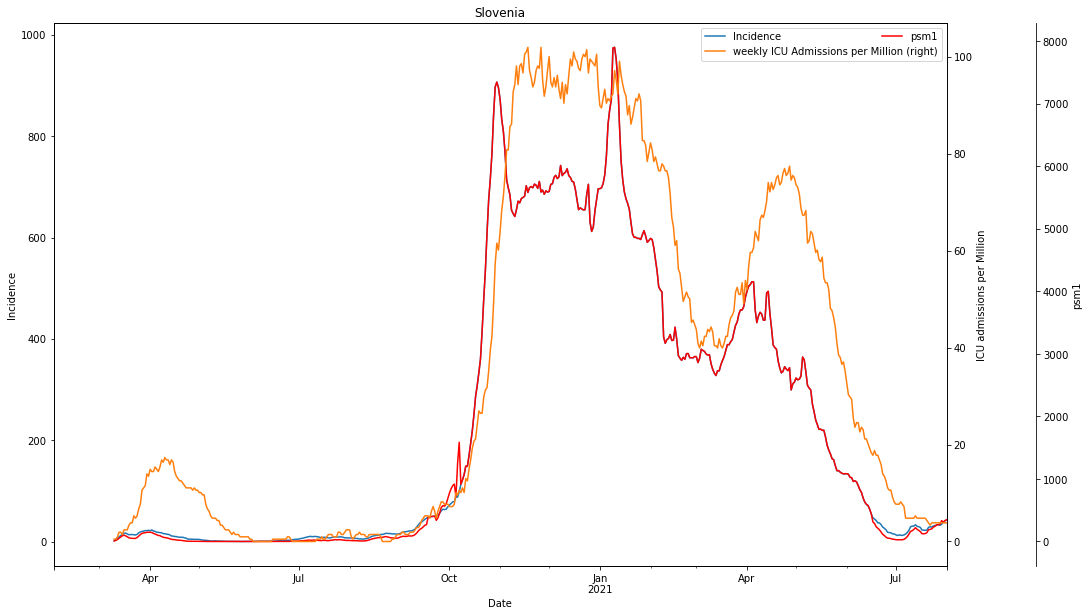

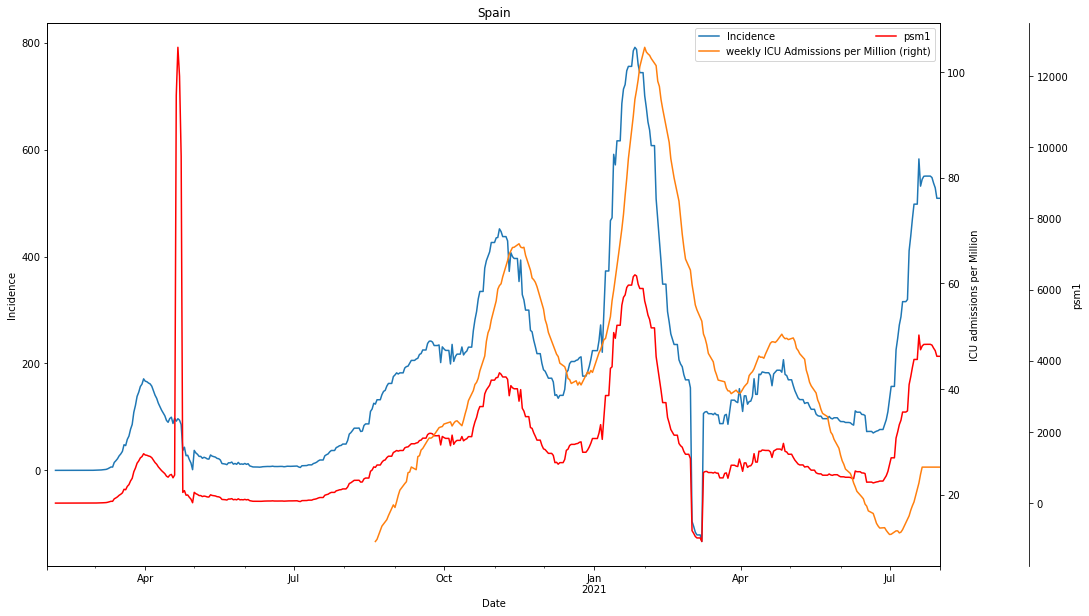

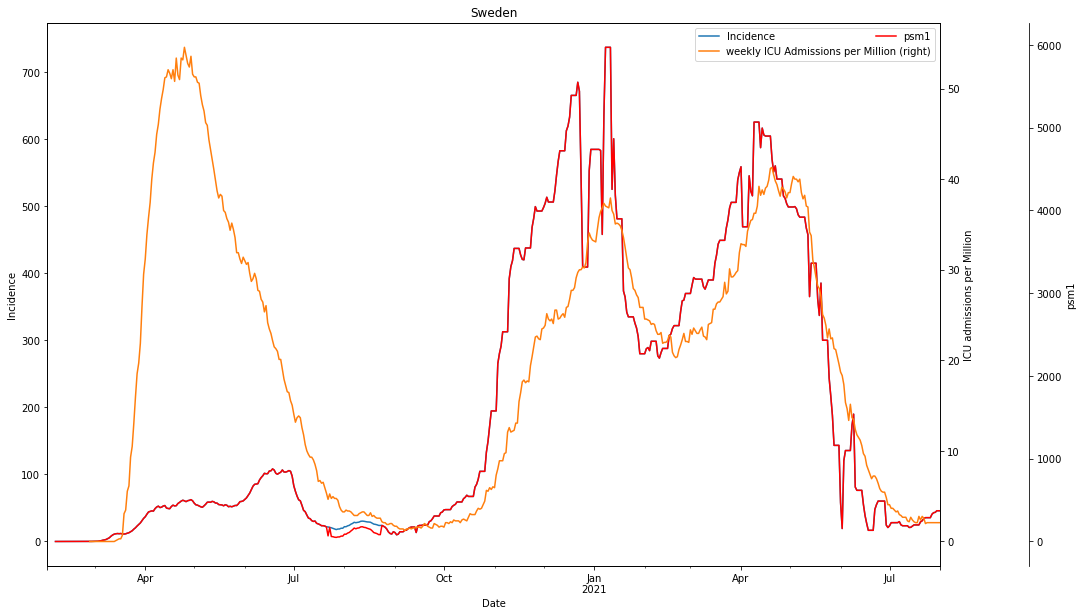

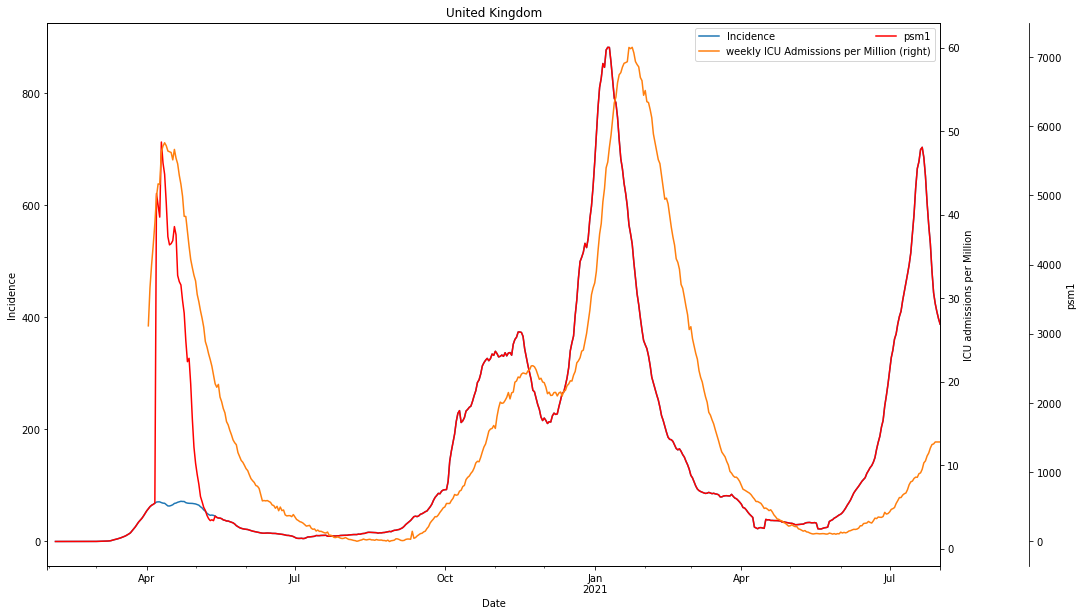

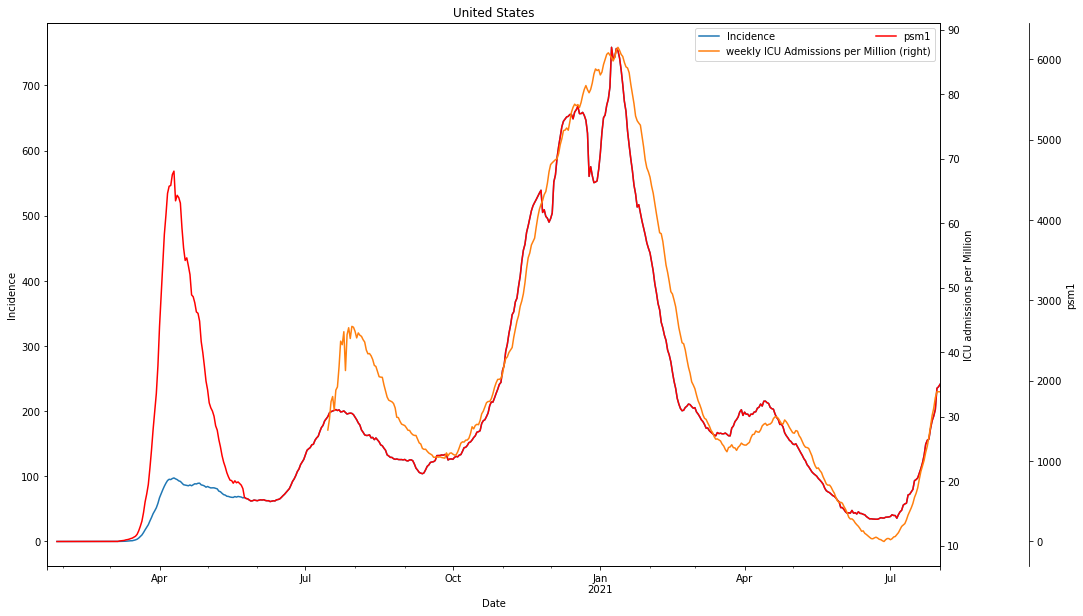

In [8]:
# Plot ICU Admissions, smoothed case numbers and positive rate

for country in icu_countries:
    df = cases_icu_grouped.get_group(country)
    # interpolate ICU occupancy linearly
    df.interpolate(method='linear', inplace=True)

    fig, ax = plt.subplots(figsize=(16,10))
    # for third variable
    ax2 = ax.twinx()
    ax2.spines['right'].set_position(('axes', 1.1))
    
    df.plot(x='date', y='new_cases_smoothed_per_million', kind='line', 
                  ylabel='Incidence', ax=ax, label='Incidence')
    df.plot(x='date', y='icu_patients_per_million', kind='line', ax=ax,
            secondary_y=True, linestyle='solid',
           label='weekly ICU Admissions per Million')
    df.plot(x='date', y='psm1', kind='line', ax=ax2, color='red',
           label='psm1', ylabel='psm1')
    
    ax.set_title(str(df['location'].unique()[0]))
    ax.right_ax.set_ylabel('ICU admissions per Million')
    ax.set_xlabel('Date')
    ax2.legend(frameon=False)
    
    fig.savefig('./../../first_fig/adj_incidence/cases/adj_incidence_cases' + country + '.pdf', bbox_inches='tight')

## Shift Incidence and Adjusted Incidence for two weeks

## First Observations:
## Objective: Build Good Predictor for ICU ADMISSIONS

### Weekly ICU Admissions
* Adjusted Incidence dampened too strong for low pr time frames (s. Italy)
    + faster decrease after peak
    + completely flat where incidence is slowly decreasing
$\implies$ Use deviation from baseline PR 
* First wave captured for some countries

### ICU Patients

<b> todo: </b>

3) shift Incidence and adjusted Incidence two weeks into the future

1) Use Deviation from baseline PR

2) mark  where PR is not available

5) scatter plots







## Old Notes

<u> Method for Evaluation </u>

<b> Premise: </b> Metric shall not be too complex in order to communicate properly to the general public why measures are taken.
Thus we do not aim at developing the most predictive metric, but one that is intuitive to communicate, accounts for the current ICU occupancy and considers testing behaviour to counteract the aforementioned illusions of Case Numbers.

<b> Consequence: </b>
Fit one dimensional linear regression of ICU occupancy onto Pandemic Severity Metric (PSM) and compare $R^2$ to case Numbers.

$\rightarrow$ Figure Out technical details. Time Shift for x? Fit Models on Sliding Window? Go from High Level Perspective downwards: How are Policies guided right now?

## Playground

In [9]:
df = pd.DataFrame({'A' : ['foo', 'bar', 'foo', 'bar',
                          'foo', 'bar'],
                   'B' : ['one', 'one', 'two', 'three',
                          'two', 'two'],
                   'C' : [1, 5, 5, 2, 5, 5],
                   'D' : [2.0, 5., 8., 1., 2., 9.]})
grouped = df.groupby('A')
grouped.transform(lambda x: (x - x.mean()) / x.std())

,C,D
0,-1.154701,-0.577350
1,0.577350,0.000000
2,0.577350,1.154701
3,-1.154701,-1.000000
4,0.577350,-0.577350
5,0.577350,1.000000


In [10]:

df

,A,B,C,D
0,foo,one,1,2.0
1,bar,one,5,5.0
2,foo,two,5,8.0
3,bar,three,2,1.0
4,foo,two,5,2.0
5,bar,two,5,9.0
